## Identifiability Test of Linear VAE on Synthetic Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ltcl
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from ltcl.datasets.utils import SimulationDataset_ts
from ltcl.modules.trainer_linear_vae_ts import AfflineVAESynthetic

In [3]:
use_cuda = True
lag = 2
length = 10
latent_size = 8
device = torch.device("cuda:0" if use_cuda else "cpu")

In [5]:
data = SimulationDataset_ts(directory = '/home/yuewen/projects/data/', 
                         transition='linear_nongaussian_ts')
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=12800, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

KeyError: 'yt_ is not a file in the archive'

In [5]:
model = AfflineVAESynthetic(latent_size,latent_size,2).to(device)

### Warm start spline flow

Do not run this block if already warm-started

In [6]:
# batch_size = 64
# spline_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.spline.parameters()), 
#                                     lr=1e-3,
#                                     weight_decay=0.0)
# # Warm-start the prior to standard normal dist
# for step in range(5000):
#     latent_size = 8
# #     y_t = torch.normal(0, 1, size=(batch_size, latent_size))
#     y_t = torch.distributions.laplace.Laplace(0,1).rsample((batch_size, latent_size))
#     dataset = y_t.to(device)
#     spline_optimizer.zero_grad()
#     z, logabsdet = model.spline(dataset)
#     logp = model.spline.base_dist.log_prob(z) + logabsdet
#     loss = -torch.mean(logp)
#     loss.backward(retain_graph=True)
#     spline_optimizer.step()
# # This checkpoint will be loaded in lvae.py
# torch.save(model.spline.state_dict(), "/home/yuewen/spline.pth")

### Load model checkpoint

In [4]:
model = model.load_from_checkpoint("/home/yuewen/code/ltcl-main-v2/logs/yuewen/toy_linear_2lag_ts/lightning_logs/version_31/checkpoints/epoch=199-step=70199.ckpt",
                                   input_dim=latent_size, z_dim=latent_size, lag=2)

NameError: name 'model' is not defined

In [8]:
model.eval()

AfflineVAESynthetic(
  (net): BetaVAE_MLP_ts(
    (encoder): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=8, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
    )
    (decoder): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Linear(in_features=8, out_features=128, bias=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Linear(in_features=128, out_features=8, bias=True)
    )
    (encode_rnn): LSTM(16, 8, batch_first=True)
    (predict_rnn): LSTM(16, 8, batch_first=True)
    (decode_rnn): LSTM(16, 8, batch_first=True)
    (beta_mu_layer): Linear(in_features=8, out_features=8, bias=True)
    (beta_sigma_layer): Linear(in_features=8, out_f

In [9]:
# model.to('cpu')

### Compute permutation and sign flip

In [10]:
for batch in train_loader:
    break
batch_size = batch['xt'].shape[0]
model.to(device)

print(batch_size)
print(batch['xt'].device)
print(model.device)

12800
cpu
cuda:0


In [11]:
# _, mu, logvar, _, _, _ = model.forward(batch)
# mu = mu.view(-1, length, lag, latent_size)
# A = mu[:,0,0,:].detach().cpu().numpy()
# B = batch['yt'][:,0,0,:].detach().cpu().numpy()
# C = np.zeros((latent_size,latent_size))
# print(mu.shape)
# print(batch['yt'].shape)
# print(A.shape)
# print(B.shape)
# print(C.shape)

In [62]:
_, mu, logvar, _, _, _ = model.forward(batch)
mu = mu.view(-1, lag, latent_size)
A = mu[:,0,:].detach().cpu().numpy()
B = batch['yt'].view(-1, lag, latent_size)[:,0,:].detach().cpu().numpy()
C = np.zeros((latent_size,latent_size))
for i in range(latent_size):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,latent_size:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(latent_size)
for i in range(latent_size):
    if np.corrcoef(B, A, rowvar=False)[i,latent_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

Permutation: [5 2 6 3 4 1 7 0]
Sign Flip: [-1. -1. -1. -1.  1. -1. -1. -1.]


Text(0.5, 1.0, 'MCC=0.83')

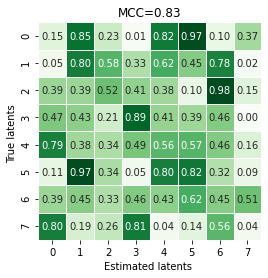

In [63]:
fig = plt.figure(figsize=(4,4))
sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
plt.xlabel("Estimated latents ") 
plt.ylabel("True latents ") 
plt.title("MCC=0.83")

In [64]:
# # Permute column here
# mu_ = mu[:,:,:,col_ind]
# # Flip sign here
# mu_ = mu_ * torch.Tensor(mask).view(1, 1, 1, latent_size).to(mu.device)
# mu_ = -mu_

# mu.shape = torch.Size([128000, 2, 8])
# Permute column here (take one episode)
mu_ = mu[:,:,col_ind]
# Flip sign here
mu_ = mu_ * torch.Tensor(mask).view(1, 1, latent_size).to(mu.device)
mu_ = -mu_

In [51]:
# # aa = torch.Tensor(mask, device=mu.device).view(1,1,1, latent_size)
# print(col_ind)
# print(mu.device)
# print(mask.shape)
# aa = torch.Tensor(mask).view(1,1,1, latent_size)
# mu.device
# print(A.shape)
# print(mu.shape)

torch.Size([128000, 2, 8])


Text(0.5, 1.0, 'Current latent variable $z_t$')

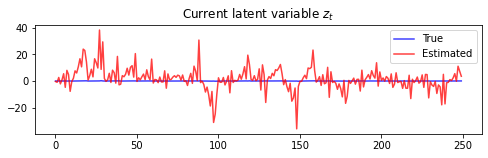

In [49]:
fig = plt.figure(figsize=(8,2))
col = 0
plt.plot(mu_[:250,-1,col].detach().cpu().numpy(), color='b', label='True', alpha=0.75)
plt.plot(batch['yt_'].view(-1, latent_size).squeeze()[:250,col].detach().cpu().numpy(), color='r', label="Estimated", alpha=0.75)
plt.legend()
plt.title("Current latent variable $z_t$")

IndexError: index 1 is out of bounds for dimension 1 with size 1

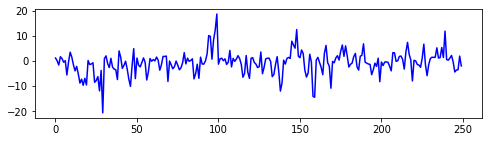

In [50]:
fig = plt.figure(figsize=(8,2))
col = 3
l = 1
plt.plot(batch['yt'].view(-1, lag, latent_size).squeeze()[:250,l,col].detach().cpu().numpy(), color='b', label='True')
plt.plot(mu[:,:-1,:][:250,l,col].detach().cpu().numpy(), color='r', label="Estimated")
plt.xlabel("Sample index")
plt.ylabel("Latent variable value")
plt.legend()
plt.title("Past latent variable $z_l$")

In [ ]:
# fig = plt.figure(figsize=(2,2))
# eps = model.sample(batch["xt"].cpu())
# eps = eps.detach().cpu().numpy()
# component_idx = 4
# sns.distplot(eps[:,component_idx], hist=False, kde=True,
#              bins=None,
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 2});
# plt.title("Learned noise prior")

### System identification (causal discovery)

In [58]:
# from ltcl.modules.components.base import GroupLinearLayer
# trans_func = GroupLinearLayer(din = 8, 
#                               dout = 8,
#                               num_blocks = 2,
#                               diagonal = False)
# b = torch.nn.Parameter(0.001 * torch.randn(1, 8))
# opt = torch.optim.Adam(trans_func.parameters(),lr=0.01)
# lossfunc = torch.nn.L1Loss()

In [59]:
# max_iters = 2
# counter = 0
# for step in range(max_iters):
#     for batch in train_loader:
#         batch_size = batch['yt'].shape[0]
#         x_recon, mu, logvar, z = model.forward(batch)
#         mu = mu.view(batch_size, -1, 8)
#         # Fix permutation before training
#         mu = mu[:,:,col_ind]
#         # Fix sign flip before training
#         mu = mu * torch.Tensor(mask, device=mu.device).view(1,1,8)
#         mu = -mu
#         pred = trans_func(mu[:,:-1,:]).sum(dim=1) + b
#         true = mu[:,-1,:]
#         loss = lossfunc(pred, true) #+ torch.mean(adaptive.lossfun((pred - true)))

#         opt.zero_grad()
#         loss.backward()
#         opt.step()
#         if counter % 100 == 0:
#             print(loss.item())
#         counter += 1

ValueError: too many values to unpack (expected 4)

### Visualize causal matrix

In [65]:
B2 = model.trans_func.w[0][col_ind][:, col_ind].detach().cpu().numpy()
B1 = model.trans_func.w[1][col_ind][:, col_ind].detach().cpu().numpy()
B1 = B1 * mask.reshape(1,-1) * (-1*mask).reshape(-1,1)
B2 = B2 * mask.reshape(1,-1) * (-1*mask).reshape(-1,1)

In [53]:
BB2 = np.load("/home/yuewen/projects/data/linear_nongaussian_ts/W2.npy")
BB1 = np.load("/home/yuewen/projects/data/linear_nongaussian_ts/W1.npy")

In [66]:
b = np.concatenate((B1,B2), axis=0)
bb = np.concatenate((BB1,BB2), axis=0)
b = b / np.linalg.norm(b, axis=0).reshape(1, -1)
bb = bb / np.linalg.norm(bb, axis=0).reshape(1, -1)
pred = (b / np.linalg.norm(b, axis=0).reshape(1, -1)).reshape(-1)
true = (bb / np.linalg.norm(bb, axis=0).reshape(1, -1)).reshape(-1)

Text(0.5, 1.0, 'Affline VAE + Spline flow')

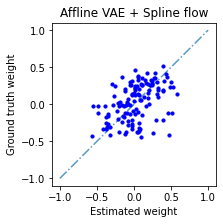

In [67]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(pred, true, s=10, cmap=plt.cm.coolwarm, zorder=10, color='b')
lims = [-1,1]

# now plot both limits against eachother
ax.plot(lims, lims, '-.', alpha=0.75, zorder=0)
ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.set_xlabel("Estimated weight")
ax.set_ylabel("Ground truth weight")
ax.set_title("Affline VAE + Spline flow")

In [56]:
# import numpy as numx

# def calculate_amari_distance(matrix_one,
#                              matrix_two,
#                              version=1):
#     """ Calculate the Amari distance between two input matrices.
#     :param matrix_one: the first matrix
#     :type matrix_one: numpy array
#     :param matrix_two: the second matrix
#     :type matrix_two: numpy array
#     :param version: Variant to use.
#     :type version: int
#     :return: The amari distance between two input matrices.
#     :rtype: float
#     """
#     if matrix_one.shape != matrix_two.shape:
#         return "Two matrices must have the same shape."
#     product_matrix = numx.abs(numx.dot(matrix_one,
#                                        numx.linalg.inv(matrix_two)))

#     product_matrix_max_col = numx.array(product_matrix.max(0))
#     product_matrix_max_row = numx.array(product_matrix.max(1))

#     n = product_matrix.shape[0]

#     """ Formula from ESLII
#     Here they refered to as "amari error"
#     The value is in [0, N-1].
#     reference:
#         Bach, F. R.; Jordan, M. I. Kernel Independent Component
#         Analysis, J MACH LEARN RES, 2002, 3, 1--48
#     """
#     amari_distance = product_matrix / numx.tile(product_matrix_max_col, (n, 1))
#     amari_distance += product_matrix / numx.tile(product_matrix_max_row, (n, 1)).T
#     amari_distance = amari_distance.sum() / (2 * n) - 1
#     amari_distance = amari_distance / (n-1)
#     return amari_distance

In [57]:
# print("Amari distance for B1:", calculate_amari_distance(B1, BB1))
# print("Amari distance for B2:", calculate_amari_distance(B2, BB2))

Amari distance for B1: 0.37615478342572345
Amari distance for B2: 0.3789290035987543
